除了计算效率之外，Python和深度学习框架本身带来的额外开销也是相当大的。 回想一下，每次我们执行代码时，Python解释器都会向深度学习框架发送一个命令，要求`将其插入到计算图中并在调度过程中处理它。 这样的额外开销可能是非常不利的。 总而言之，我们最好用向量化（和矩阵）。`m

In [2]:
%matplotlib inline
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

timer = d2l.Timer()
A = torch.zeros(256, 256)
B = torch.randn(256, 256)
C = torch.randn(256, 256)

按元素分配只需遍历分别为B和C的所有行和列，即可将该值分配给A。

In [3]:
# 逐元素计算A=BC
timer.start()
for i in range(256):
    for j in range(256):
        A[i, j] = torch.dot(B[i, :], C[:, j])
timer.stop()

0.5745527744293213

更快的策略是执行按列分配

In [4]:
# 逐列计算A=BC
timer.start()
for j in range(256):
    A[:, j] = torch.mv(B, C[:, j])
timer.stop()

0.008006095886230469

最有效的方法是在一个区块中执行整个操作。让我们看看它们各自的操作速度是多少

In [5]:
# 一次性计算A=BC
timer.start()
A = torch.mm(B, C)
timer.stop()

# 乘法和加法作为单独的操作（在实践中融合）
gigaflops = [2/i for i in timer.times]
print(f'performance in Gigaflops: element {gigaflops[0]:.3f}, '
      f'column {gigaflops[1]:.3f}, full {gigaflops[2]:.3f}')

performance in Gigaflops: element 3.481, column 249.810, full 285.463


处理单个观测值需要我们执行许多单一矩阵-矢量（甚至矢量-矢量）乘法，这耗费相当大，而且对应深度学习框架也要巨大的开销。 这既适用于计算梯度以更新参数时，也适用于用神经网络预测。

我们选择一个足够大的小批量，它可以提供良好的计算效率同时仍适合GPU的内存。 下面，我们来看看这些高效的代码。 在里面我们执行相同的矩阵-矩阵乘法，但是这次我们将其一次性分为64列的“小批量”。

In [6]:
timer.start()
for j in range(0, 256, 64):
    A[:, j:j+64] = torch.mm(B, C[:, j:j+64])
timer.stop()
print(f'performance in Gigaflops: block {2 / timer.times[3]:.3f}')

performance in Gigaflops: block 1999.192


In [7]:
#@save
d2l.DATA_HUB['airfoil'] = (d2l.DATA_URL + 'airfoil_self_noise.dat',
                           '76e5be1548fd8222e5074cf0faae75edff8cf93f')

#@save
def get_data_ch11(batch_size=10, n=1500):
    data = np.genfromtxt(d2l.download('airfoil'),
                         dtype=np.float32, delimiter='\t')
    data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))
    data_iter = d2l.load_array((data[:n, :-1], data[:n, -1]),
                               batch_size, is_train=True)
    return data_iter, data.shape[1]-1

In [8]:
def sgd(params, states, hyperparams):
    for p in params:
        p.data.sub_(hyperparams['lr'] * p.grad)
        p.grad.data.zero_()

实现一个通用的训练函数，以方便后面介绍的其他优化算法使用。 它初始化了一个线性回归模型，然后可以使用小批量随机梯度下降以及后续小节介绍的其他算法来训练模型。

In [9]:
#@save
def train_ch11(trainer_fn, states, hyperparams, data_iter,
               feature_dim, num_epochs=2):
    # 初始化模型
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1),
                     requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    # 训练模型
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss),))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]

看看批量梯度下降的优化是如何进行的。 这可以通过将小批量设置为1500（即样本总数）来实现。 因此，模型参数每个迭代轮数只迭代一次。

loss: 0.249, 0.026 sec/epoch


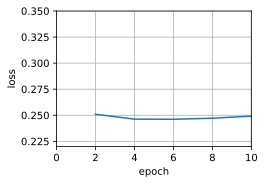

In [10]:
def train_sgd(lr, batch_size, num_epochs=2):
    data_iter, feature_dim = get_data_ch11(batch_size)
    return train_ch11(
        sgd, None, {'lr': lr}, data_iter, feature_dim, num_epochs)

gd_res = train_sgd(1, 1500, 10)

当批量大小为1时，优化使用的是随机梯度下降。 为了简化实现，我们选择了很小的学习率。 在随机梯度下降的实验中，每当一个样本被处理，模型参数都会更新。 在这个例子中，这相当于每个迭代轮数有1500次更新。 可以看到，目标函数值的下降在1个迭代轮数后就变得较为平缓。 尽管两个例子在一个迭代轮数内都处理了1500个样本，但实验中随机梯度下降的一个迭代轮数耗时更多。 这是因为随机梯度下降更频繁地更新了参数，而且一次处理单个观测值效率较低。

loss: 0.243, 0.033 sec/epoch


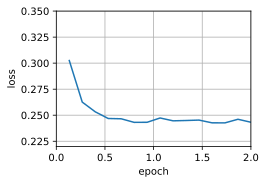

In [11]:
sgd_res = train_sgd(0.005, 1)

最后，当批量大小等于100时，我们使用小批量随机梯度下降进行优化。 每个迭代轮数所需的时间比随机梯度下降和批量梯度下降所需的时间短。

loss: 0.243, 0.002 sec/epoch


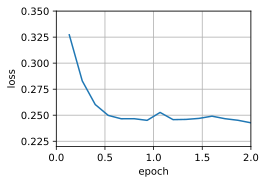

In [12]:
mini1_res = train_sgd(.4, 100)

将批量大小减少到10，每个迭代轮数的时间都会增加，因为每批工作负载的执行效率变得更低。

loss: 0.247, 0.005 sec/epoch


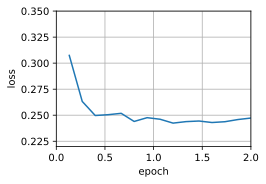

In [13]:
mini2_res = train_sgd(.05, 10)

现在我们可以比较前四个实验的时间与损失。 可以看出，尽管在处理的样本数方面，随机梯度下降的收敛速度快于梯度下降，但与梯度下降相比，它需要更多的时间来达到同样的损失，因为逐个样本来计算梯度并不那么有效。 小批量随机梯度下降能够平衡收敛速度和计算效率。 大小为10的小批量比随机梯度下降更有效； 大小为100的小批量在运行时间上甚至优于梯度下降。

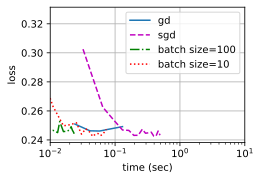

In [14]:
d2l.set_figsize([6, 3])
d2l.plot(*list(map(list, zip(gd_res, sgd_res, mini1_res, mini2_res))),
         'time (sec)', 'loss', xlim=[1e-2, 10],
         legend=['gd', 'sgd', 'batch size=100', 'batch size=10'])
d2l.plt.gca().set_xscale('log')

用深度学习框架自带算法实现一个通用的训练函数

In [15]:
#@save
def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    # 初始化模型
    net = nn.Sequential(nn.Linear(5, 1))
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)

    optimizer = trainer_fn(net.parameters(), **hyperparams)
    loss = nn.MSELoss(reduction='none')
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            optimizer.zero_grad()
            out = net(X)
            y = y.reshape(out.shape)
            l = loss(out, y)
            l.mean().backward()
            optimizer.step()
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                # MSELoss计算平方误差时不带系数1/2
                animator.add(n/X.shape[0]/len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss) / 2,))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')

loss: 0.242, 0.005 sec/epoch


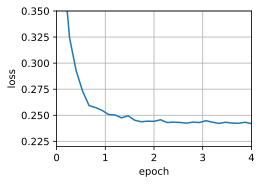

In [16]:
data_iter, _ = get_data_ch11(10)
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr': 0.01}, data_iter)